Data shape: (1532, 402, 355)


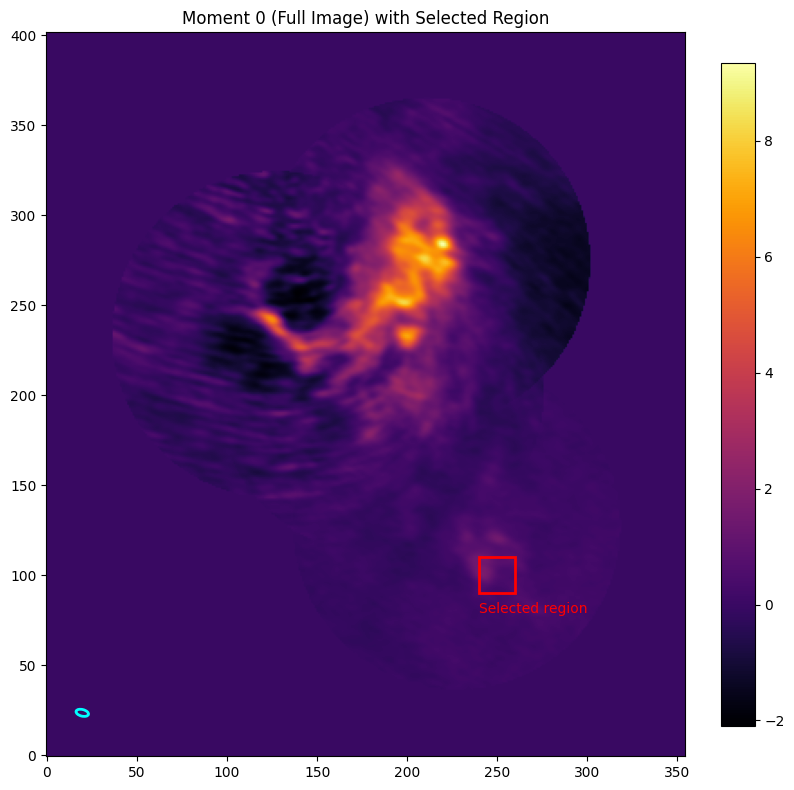

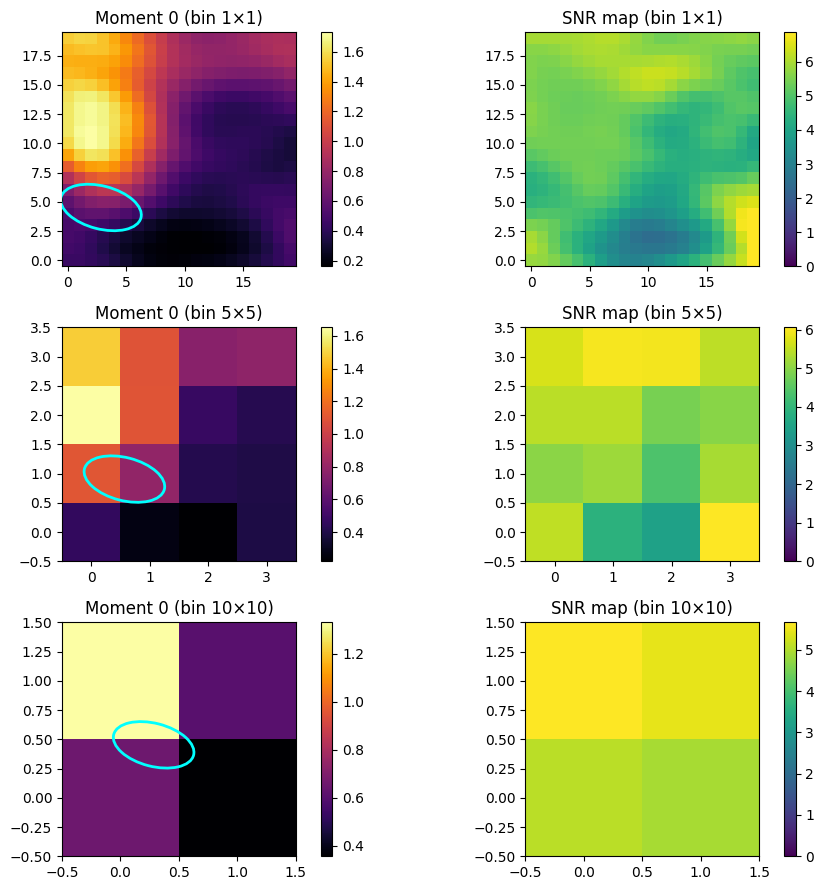

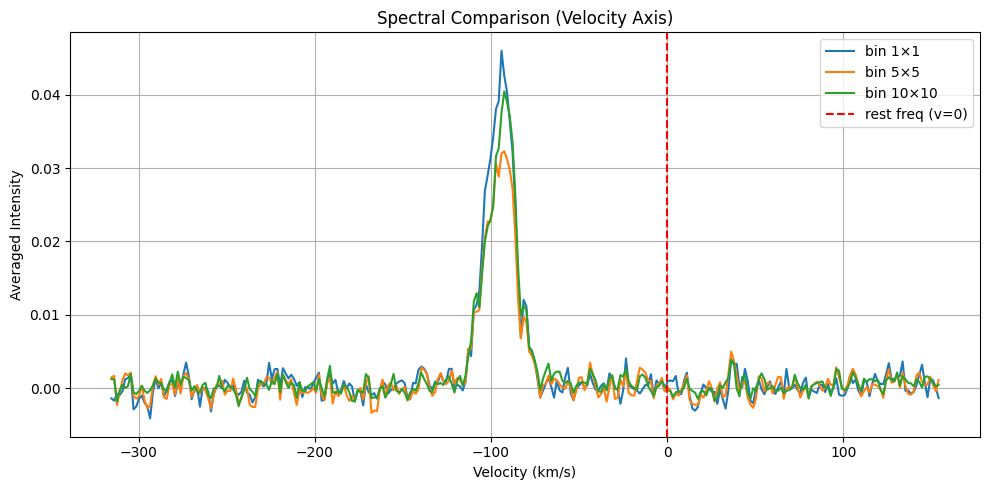

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import matplotlib.patches as patches
from matplotlib.patches import Ellipse

# ==== Set input file and channel range ====
cube_file = "/Users/ccc/Desktop/research/baobab/ALMA_project/datacubes/spw0.fits"
v1, v2 = 700, 1000  # Channel range to analyze

# ==== Read FITS data ====
data = fits.getdata(cube_file)       # shape: (stokes, freq, y, x)
header = fits.getheader(cube_file)
cube = data[0, :, :, :]
print(f"Data shape: {cube.shape}")

# ==== Extract specified channel region ====
# x1, x2, y1, y2 = 210, 240, 50, 80  # selected region
x1, x2, y1, y2 = 240, 260, 90, 110  # selected region

subcube = cube[v1:v2, y1:y2, x1:x2]
channels = np.arange(v1, v2)

# ==== Binning function ====
def spatial_bin_cube(cube, bin_factor):
    freq, ny, nx = cube.shape
    new_ny = ny // bin_factor
    new_nx = nx // bin_factor
    cube = cube[:, :new_ny*bin_factor, :new_nx*bin_factor]
    reshaped = cube.reshape(freq, new_ny, bin_factor, new_nx, bin_factor)
    return reshaped.mean(axis=(2, 4))

# ==== Set binning sizes ====
bin_sizes = [1, 5, 10]
moment0_maps = {}
snr_maps = {}

for b in bin_sizes:
    binned = subcube if b == 1 else spatial_bin_cube(subcube, b)
    moment0 = np.nansum(binned, axis=0)
    rms = np.nanstd(binned, axis=0) * np.sqrt(binned.shape[0])
    snr = moment0 / (rms + 1e-10)
    moment0_maps[b] = moment0
    snr_maps[b] = snr

# ==== Show full Moment 0 map with selected region ====
moment0_full = np.nansum(cube[v1:v2, :, :], axis=0)
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow(moment0_full, origin='lower', cmap='inferno')
plt.colorbar(im, ax=ax, fraction=0.046)
ax.set_title("Moment 0 (Full Image) with Selected Region")

# Draw selected region
rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)
ax.text(x1, y1-5, "Selected region", color='red', fontsize=10, va='top')

# Draw beam
bmaj = header.get('BMAJ', 0.0)
bmin = header.get('BMIN', 0.0)
bpa = header.get('BPA', 0.0)
cdelt1 = abs(header['CDELT1'])
cdelt2 = abs(header['CDELT2'])
bmaj_pix = bmaj / cdelt2 if cdelt2 else 0
bmin_pix = bmin / cdelt1 if cdelt1 else 0
beam_x = bmin_pix / 2 + moment0_full.shape[1] * 0.05
beam_y = bmaj_pix / 2 + moment0_full.shape[0] * 0.05
beam = Ellipse((beam_x, beam_y), width=bmin_pix, height=bmaj_pix, angle=bpa,
               edgecolor='cyan', facecolor='none', lw=2, zorder=10)
ax.add_patch(beam)
plt.tight_layout()
plt.show()

# ==== Show Moment 0 / SNR maps ====
fig, axes = plt.subplots(len(bin_sizes), 2, figsize=(10, 3*len(bin_sizes)))
for i, b in enumerate(bin_sizes):
    ax0, ax1 = axes[i]
    im0 = ax0.imshow(moment0_maps[b], origin='lower', cmap='inferno')
    ax0.set_title(f'Moment 0 (bin {b}×{b})')
    plt.colorbar(im0, ax=ax0, fraction=0.046)

    bmaj_pix = bmaj / (cdelt2 * b) if cdelt2 else 0
    bmin_pix = bmin / (cdelt1 * b) if cdelt1 else 0
    beam_x = bmin_pix / 2 + moment0_maps[b].shape[1] * 0.05
    beam_y = bmaj_pix / 2 + moment0_maps[b].shape[0] * 0.05
    beam = Ellipse((beam_x, beam_y), width=bmin_pix, height=bmaj_pix, angle=bpa,
                   edgecolor='cyan', facecolor='none', lw=2, zorder=10)
    ax0.add_patch(beam)

    im1 = ax1.imshow(snr_maps[b], origin='lower', cmap='viridis',
                     vmin=0, vmax=np.nanpercentile(snr_maps[b], 99))
    ax1.set_title(f'SNR map (bin {b}×{b})')
    plt.colorbar(im1, ax=ax1, fraction=0.046)
plt.tight_layout()
plt.show()

# ==== Spectral comparison ====
fig, ax = plt.subplots(figsize=(10, 5))
ny, nx = subcube.shape[1:]
y0, x0 = ny // 2, nx // 2

velocity_axis = header['CRVAL3'] + (np.arange(v1, v2) + 1 - header['CRPIX3']) * header['CDELT3']  # m/s
velocity_axis_kms = velocity_axis / 1e3  #  km/s

for b in bin_sizes:
    cube_use = subcube if b == 1 else spatial_bin_cube(subcube, b)
    yb, xb = y0 // b, x0 // b
    roi = cube_use[:, yb:yb + 1, xb:xb + 1] if b > 1 else cube_use[:, y0 - 2:y0 + 3, x0 - 2:x0 + 3]
    spec = roi.mean(axis=(1, 2))
    ax.plot(velocity_axis_kms, spec, label=f'bin {b}×{b}')

# Add vertical line at rest velocity (v = 0 km/s)
ax.axvline(0, color='r', linestyle='--', label='rest freq (v=0)')

ax.set_xlabel("Velocity (km/s)")
ax.set_ylabel("Averaged Intensity")
ax.set_title("Spectral Comparison (Velocity Axis)")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


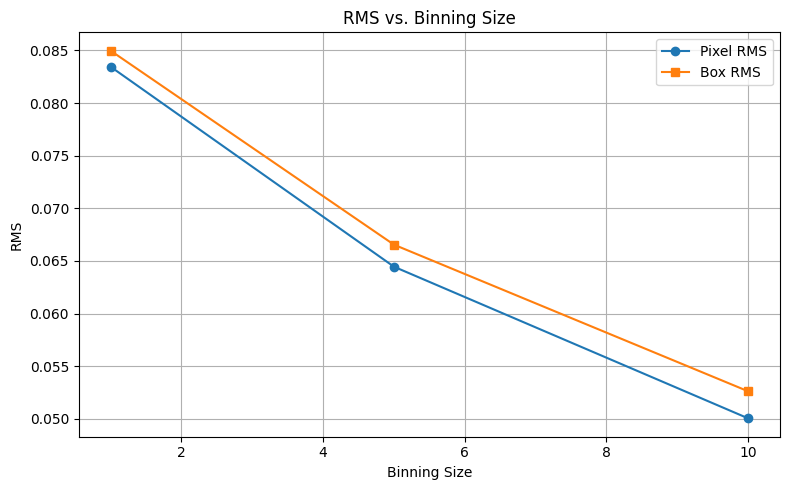

In [48]:
# ==== Plot RMS vs. Binning Size ====
# This section collects RMS values for different binning sizes and plots them.
# Collect RMS values for plotting
rms_pixel_list = []
rms_box_list = []

for b in bin_sizes:
    binned = subcube if b == 1 else spatial_bin_cube(subcube, b)
    rms_pixel = np.nanstd(binned, axis=0) * np.sqrt(binned.shape[0])

    # Box RMS: use the originally selected region, adjust for binning
    if b == 1:
        box_region = binned[:, :, :]
    else:
        # Map original region to binned region
        y1b, y2b = 0, binned.shape[1]
        x1b, x2b = 0, binned.shape[2]
        box_region = binned[:, y1b:y2b, x1b:x2b]
    rms_box = np.nanstd(box_region) * np.sqrt(binned.shape[0])


    rms_pixel_list.append(np.nanmean(rms_pixel))
    rms_box_list.append(rms_box)

# Plot RMS diagram
plt.figure(figsize=(8, 5))
plt.plot(bin_sizes, rms_pixel_list, 'o-', label='Pixel RMS')
plt.plot(bin_sizes, rms_box_list, 's-', label='Box RMS')
plt.xlabel('Binning Size')
plt.ylabel('RMS')
plt.title('RMS vs. Binning Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()